# Mixup

This implementation of [_mixup: BEYOND EMPIRICAL RISK MINIMIZATION_](https://arxiv.org/pdf/1710.09412.pdf) mixup has been done following the paper's indications and the FastAI implementation guide.

The integration to the data pipeline will be done at the `DataBatches` level. 

# Dev

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys; sys.path.append("/data/miguel/practicum/DL-Medical-Physics")
import warnings; warnings.filterwarnings('ignore')

from core import *
from data_manipulation import Transform, RandomRotation, Flip, RandomCrop, balance_obs, multi_label_2_binary, DataBatches


seed = 42
r_pix = 8
# IDX = 6 # Pneumonia
BATCH_SIZE = 16
EPOCHS = 10
TRANSFORMATIONS = [RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=r_pix)]
PRETRAINED = True
NORMALIZE = True # ImageNet
FREEZE = True
GRADUAL_UNFREEZING = True
DATA = '14diseases'


BASE_PATH = Path('../..')
PATH = BASE_PATH/'data'
IMG_FOLDER = PATH/'ChestXRay-250'


In [5]:
train_df = pd.read_csv(PATH/'train_df.csv')
valid_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")

train_dl = DataBatches(df=train_df, transforms=TRANSFORMATIONS, shuffle=True,
                       img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, data=DATA,
                       r_pix=r_pix, normalize=NORMALIZE, seed=seed)

valid_dl = DataBatches(df=valid_df, transforms=None, shuffle=False,
                       img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, data=DATA,
                       r_pix=r_pix, normalize=NORMALIZE, seed=seed)

test_dl = DataBatches(df=valid_df, transforms=TRANSFORMATIONS, shuffle=False, 
                      img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, data=DATA,
                      r_pix=r_pix, normalize=NORMALIZE, seed=seed)

In [6]:
train_dl.set_random_choices()
x,y = next(iter(train_dl))
x.shape, y.shape

(torch.Size([16, 3, 234, 234]), torch.Size([16, 14]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


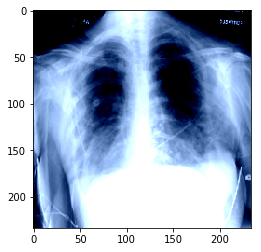

In [15]:
plt.imshow(x[0].permute(1,2,0).cpu().numpy())

In [16]:
batch_size = 16

t = np.random.beta(.4,.4, size=batch_size)[None]
t = torch.tensor(np.max(np.concatenate([t, 1-t]), 0).reshape(-1, 1, 1, 1),  dtype = torch.float).cuda()
idx = np.random.permutation(range(batch_size))

t[0,0,0,0]=.5

x,y = (t*x + (1-t)*x[idx]), (t[:,:,0,0]*y + (1-t[:,:,0,0])*y[idx])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


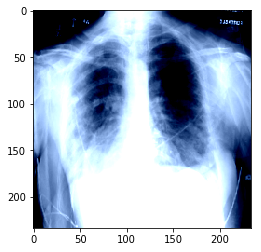

In [17]:
plt.imshow(x[0].permute(1,2,0).cpu().numpy())

# Wrap it up in a nice class

In [ ]:
class MixUp:
    '''
    Assumes it's running on cuda. 
    
    Implementation can be made more efficient. 
    '''
    
    def __init__(self, alpha=.4):
        self.alpha = alpha
        
    def __call__(self, x, y):
        batch_size = x.shape[0]

        t = np.random.beta(.4,.4, size=batch_size)[None]
        t = torch.tensor(np.max(np.concatenate([t, 1-t]), 0).reshape(-1, 1, 1, 1),  dtype = torch.float).cuda()
        idx = np.random.permutation(range(batch_size))

        return (t*x + (1-t)*x[idx]), (t[:,:,0,0]*y + (1-t[:,:,0,0])*y[idx])
        